In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

%matplotlib inline
plt.style.use('seaborn')

DATA_DIR = "../bigdata/"

In [2]:
# Icebreaker Sisu and vessels Aura and BBC Virginia
SISU_MMSI=230289000
AURA_MMSI=230601000
BBC_MMSI=305463000
mmsis = [SISU_MMSI, AURA_MMSI, BBC_MMSI]

vm = pd.read_csv(DATA_DIR + 'vessel_metadatas-1-week-20180315.csv', parse_dates = ['timestamp'])
vm = vm[vm['mmsi'].isin(mmsis)]
vm = vm.sort_values(by=['timestamp'])

vl = pd.read_csv(DATA_DIR + 'vessel_locations-1-week-20180315.csv', parse_dates = ['timestamp'])
vl = vl[vl['mmsi'].isin(mmsis)]
vl = vl.sort_values(by=['timestamp'])

# Dataset of winter navigation

The dataset consists of Automatic Identification System (AIS) messages. First, the vessels send a **vessel metadata** message every five minutes (see [AIS message specifciation](https://www.navcen.uscg.gov/?pageName=AISMessagesAStatic)) . Second, the **vessel location** is sent even multiple times per second depending on the maneuvers the vessel performs.

In the following sample of the dataset, icebreaker **Sisu** tows a vessel called **Aura**. There is a third vessel in the convoy, too, namely **BBC Virginia**.

## Vessel metadata

In [3]:
vm.head(7)

,timestamp,name,ship_type,callsign,imo,mmsi,destination,eta,draught,pos_type,reference_point_a,reference_point_b,reference_point_c,reference_point_d
399352,2018-03-15 00:00:16.951,AURA,70,OJMS,9395276,230601000,TORNIO,229888,43,1,10,92,10,9
399354,2018-03-15 00:00:17.371,AURA,70,OJMS,9395276,230601000,TORNIO,229888,43,1,10,92,10,9
399489,2018-03-15 00:01:00.341,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,11,13
399495,2018-03-15 00:01:00.680,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,11,13
400701,2018-03-15 00:07:00.845,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,11,13
400705,2018-03-15 00:07:01.162,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,11,13
401166,2018-03-15 00:09:30.715,BBC VIRGINIA,70,V2EK8,9501277,305463000,FI TOR,226112,52,1,125,13,11,10


Fields:
* timestamp: when the AIS 5 metadata message was sent
* name: of the vessel
* ship_type: (90 = icebreakers and some others)
* callsign: a unique alphanumeric identity
* mmsi: a unique identifier of an AIS transponder, for instance beginning with 2=Europe, 6=Africa (see [Maritime Mobile Service Identity](https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity))
* destination: the current destination of the ship as text (not 100% correct, for instance, if the crew has forgotten to update the destination)
* draught, i.e., how deep is the vessel moving currently (see [Calculation of draught](http://www.viadonau.org/en/economy/online-services/calculation-of-the-draught-loaded/))
* pos_type: is the position accurate?
* refence points A-D: the width and breadth of the vessel (see [AIS message specifciation](https://www.navcen.uscg.gov/?pageName=AISMessagesAStatic))

## Vessel location

In [7]:
vl.head()

,timestamp,mmsi,lon,lat,sog,cog,heading
653,2018-03-15 00:00:45.608,305463000,21.385935,63.688148,8.9,50.6,49
674,2018-03-15 00:00:46.074,305463000,21.385935,63.688148,8.9,50.6,49
921,2018-03-15 00:01:03.812,305463000,21.387205,63.688658,8.1,49.0,50
944,2018-03-15 00:01:04.125,305463000,21.387205,63.688658,8.1,49.0,50
1179,2018-03-15 00:01:22.183,305463000,21.388385,63.689067,8.0,50.7,50


Fields:
* timestamp: transponder send time of the observation
* mmsi: a unique identifier of an AIS transponder, for instance beginning with 2=Europe, 6=Africa (see [Maritime Mobile Service Identity](https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity))
* sog: speed over ground
* cog: course over ground (0-360) which may differ from [heading](https://en.wikipedia.org/wiki/Course_(navigation)
* heading: where the head of the vessel points to (0-360)

In [ ]:
# %load ../ais/analysis.py
import pandas as pd
import numpy as np

MOVE_SPEED_THRESHOLD = 5
STOP_SPEED_THRESHOLD = 0.5

PREVIOUS_OBSERVATIONS_TIME_FRAME = 5 # store N minutues of observations

def filter_previous_observations_by_timestamp(df):
    if len(df) > 0:
        return df[lambda x: x['timestamp'] >= (df['timestamp'] - pd.Timedelta(15, unit='m'))]
    else:
        return df


def is_sudden_stop(d, prev):
    sog_mean = prev['sog'].mean()
    return sog_mean >= MOVE_SPEED_THRESHOLD and \
           d['sog'] < STOP_SPEED_THRESHOLD and \
           len(prev) > 1 and (prev['sudden_stopping'] == False).all()


def append_sudden_stopping(ais):
    ais.assign(sudden_stopping = None)
    vessels = {}

    for i, d in ais.iterrows():
        mmsi = d['mmsi']
        if not mmsi in vessels.keys():
            vessels[mmsi] = {}
            vessels[mmsi]['previous_observations'] = pd.DataFrame(columns=ais.columns)

        prev = filter_previous_observations_by_timestamp(vessels[mmsi]['previous_observations'])
        vessels[mmsi]['previous_observations'] = prev

        ais.set_value(i, 'sudden_stopping', is_sudden_stop(d, prev))

        vessels[mmsi]['previous_observations'] = vessels[mmsi]['previous_observations'].append(ais.loc[i])

    return ais


def merge_vessel_meta_and_location_data(vm, vl):
    """ Merges dataframes (vessel meta data and vessel location) into a single dataframe.
    Assumes that the dataframes are for a single mmsi and ordered by timestamp.
    """

    mmsis = vl['mmsi'].unique()

    df = None
    for mmsi in mmsis:
        result = merge_single_vessel_meta_and_location_data(vm[vm['mmsi'] == mmsi], vl[vl['mmsi'] == mmsi])
        if df is None:
            df = result
        else:
            df = df.append(result, ignore_index=True)

    return df


def merge_single_vessel_meta_and_location_data(vm, vl):
    vm = vm.sort_values('timestamp')
    vl = vl.sort_values('timestamp')

    vl_colnames = ['timestamp', 'mmsi', 'lon', 'lat', 'sog','cog', 'heading']
    vm_colnames = ['name', 'ship_type', 'callsign', 'imo', 'destination', 'eta', 'draught', 'pos_type', 'reference_point_a', 'reference_point_b', 'reference_point_c', 'reference_point_d'];

    df = pd.DataFrame(columns = vl_colnames + vm_colnames)

    vm_index = 0
    vl_index = 0

    while vl_index < len(vl):
        if vl.iloc[vl_index].timestamp > vm.iloc[vm_index].timestamp:
            while vm_index + 1 < len(vm) and vm.iloc[vm_index + 1].timestamp < vl.iloc[vl_index].timestamp:
                vm_index += 1

            if vm_index >= len(vm):
                break

            df.loc[len(df)] = merge_vessel_row(vl, vl_index, vl_colnames, vm, vm_index, vm_colnames)
        vl_index += 1

    return df


def merge_vessel_row(vl, vl_index, vl_colnames, vm, vm_index, vm_colnames):
    d = {}
    for col_name in vl_colnames:
        d[col_name] = vl.iloc[vl_index][col_name]
    for col_name in vm_colnames:
        d[col_name] = vm.iloc[vm_index][col_name]
    return d


In [9]:
vm_sisu = vm[(vm['mmsi'] == SISU_MMSI) & (vm['timestamp'] > '2018-03-17 12:38:00.000') & (vm['timestamp'] < '2018-03-17 12:45:00.000')]
vm_sisu

,timestamp,name,ship_type,callsign,imo,mmsi,destination,eta,draught,pos_type,reference_point_a,reference_point_b,reference_point_c,reference_point_d
1099951,2018-03-17 12:38:56.430,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,12,12
1099957,2018-03-17 12:38:57.585,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,12,12
1101044,2018-03-17 12:44:56.644,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,12,12
1101051,2018-03-17 12:44:57.864,SISU,90,OHMW,7359656,230289000,ICEBREAKING CH 8,76352,80,1,35,70,12,12


In [10]:
vl_sisu = vl[(vl['mmsi'] == SISU_MMSI) & (vl['timestamp'] > '2018-03-17 12:38:00.000') & (vl['timestamp'] < '2018-03-17 12:45:00.000')]
vl_sisu

,timestamp,mmsi,lon,lat,sog,cog,heading
2917508,2018-03-17 12:38:00.548,230289000,20.747390,61.017782,12.6,3.5,4
2917651,2018-03-17 12:38:09.728,230289000,20.747463,61.018363,12.6,4.2,4
2917679,2018-03-17 12:38:10.446,230289000,20.747463,61.018363,12.6,4.2,4
2917844,2018-03-17 12:38:20.053,230289000,20.747500,61.019000,12.6,3.8,4
2917868,2018-03-17 12:38:20.855,230289000,20.747500,61.019000,12.6,3.8,4
2918001,2018-03-17 12:38:27.331,230289000,20.747602,61.019467,12.5,3.9,4
2918009,2018-03-17 12:38:29.922,230289000,20.747602,61.019467,12.5,3.9,4
2918186,2018-03-17 12:38:37.724,230289000,20.747682,61.020107,12.5,3.0,4
2918196,2018-03-17 12:38:40.274,230289000,20.747682,61.020107,12.5,3.0,4
2918365,2018-03-17 12:38:47.815,230289000,20.747752,61.020688,12.5,3.2,4


In [11]:
sisu = merge_vessel_meta_and_location_data(vm_sisu, vl_sisu)

In [12]:
sisu.head()

,timestamp,mmsi,lon,lat,sog,cog,heading,name,ship_type,callsign,imo,destination,eta,draught,pos_type,reference_point_a,reference_point_b,reference_point_c,reference_point_d
0,2018-03-17 12:39:00.439,230289000,20.747833,61.021333,12.7,3.7,4,SISU,90,OHMW,7359656,ICEBREAKING CH 8,76352,80,1,35,70,12,12
1,2018-03-17 12:39:01.269,230289000,20.747833,61.021333,12.7,3.7,4,SISU,90,OHMW,7359656,ICEBREAKING CH 8,76352,80,1,35,70,12,12
2,2018-03-17 12:39:07.956,230289000,20.747893,61.021855,12.7,3.9,4,SISU,90,OHMW,7359656,ICEBREAKING CH 8,76352,80,1,35,70,12,12
3,2018-03-17 12:39:10.324,230289000,20.747893,61.021855,12.7,3.9,4,SISU,90,OHMW,7359656,ICEBREAKING CH 8,76352,80,1,35,70,12,12
4,2018-03-17 12:39:18.491,230289000,20.748000,61.022500,12.6,3.0,4,SISU,90,OHMW,7359656,ICEBREAKING CH 8,76352,80,1,35,70,12,12


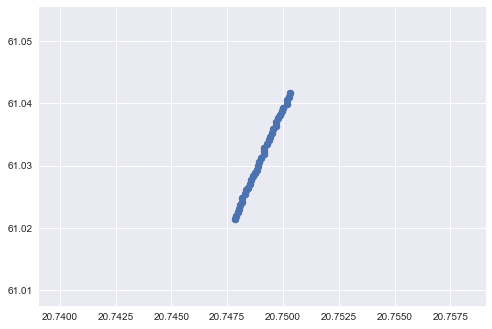

In [13]:
plt.scatter(sisu.lon, sisu.lat)

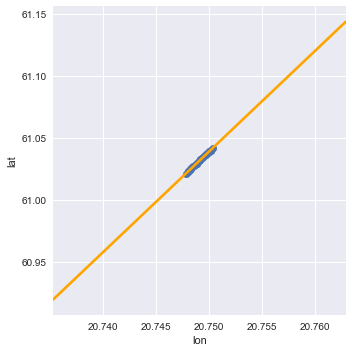

In [14]:
sns.lmplot(x="lon", y="lat", data=sisu, line_kws={'color': 'orange'})

In [15]:
plotly_username=%env plotly_username
plotly_api_key=%env plotly_api_key

In [16]:
print("Accessing plotly as user {}".format(plotly_username))

Accessing plotly as user timole


In [22]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly_username=%env plotly_username
plotly_api_key=%env plotly_api_key

plotly.tools.set_credentials_file(username=plotly_username, api_key=plotly_api_key)


In [26]:
tr = go.Scatter3d(
    x=sisu.lon,
    y=sisu.lat,
    z=sisu.timestamp - min(sisu.timestamp),
    mode='markers'
)

fig = go.Figure(data=[tr])
py.iplot(fig, filename='3d-scatter')